In [139]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [140]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
from scipy import stats
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [141]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [142]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num

In [143]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# Load Data

## AIRI Data

In [144]:
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
#This file's calendar isn't recognized when using xr.open_dataset. The above workaround is from: 
#https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
# "M" means "month end frequency" (see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
precip = airi_dat['precip']

In [145]:
#Get precip anomalies
'''
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim
'''
precip_anomfull = precip

In [146]:
def is_jjas(month):
    return (month >= 6) & (month <= 9)
precip = precip_anomfull.sel(time=is_jjas(precip_anomfull['time.month'])).groupby('time.year').sum(dim='time')

monthtime = pd.date_range('1871-01-01', freq='Y', periods=146)
precip['year'] = monthtime
precip = precip.rename({'year': 'time'})

In [147]:
precip_subset1 = precip.sel(time=slice('1900-01-01','1901-12-31'))
precip_subset2 = precip.sel(time=slice('1903-01-01','1906-12-31'))
precip_subset3 = precip.sel(time=slice('1908-01-01','1911-12-31'))
precip_subset4 = precip.sel(time=slice('1913-01-01','1913-12-31'))
precip_subset5 = precip.sel(time=slice('1915-01-01','1918-12-31'))
precip_subset6 = precip.sel(time=slice('1920-01-01','1921-12-31'))
precip_subset7 = precip.sel(time=slice('1923-01-01','1927-12-31'))
precip_subset8 = precip.sel(time=slice('1929-01-01','1931-12-31'))
precip_subset9 = precip.sel(time=slice('1934-01-01','1939-12-31'))
precip_subset10 = precip.sel(time=slice('1941-01-01','1948-12-31'))
precip_subset11 = precip.sel(time=slice('1951-01-01','1955-12-31'))
precip_subset12 = precip.sel(time=slice('1957-01-01','1958-12-31'))
precip_subset13 = precip.sel(time=slice('1960-01-01','1962-12-31'))
precip_subset13 = precip.sel(time=slice('1964-01-01','1965-12-31'))
precip_subset14 = precip.sel(time=slice('1967-01-01','1971-12-31'))
precip_subset15 = precip.sel(time=slice('1973-01-01','1976-12-31'))
precip_subset16 = precip.sel(time=slice('1978-01-01','1979-12-31'))
precip_subset17 = precip.sel(time=slice('1981-01-01','1982-12-31'))
precip_subset18 = precip.sel(time=slice('1984-01-01','1991-12-31'))
precip_subset19 = precip.sel(time=slice('1993-01-01','1998-12-31'))
precip_subset20 = precip.sel(time=slice('2000-01-01','2002-12-31'))
precip_subset21 = precip.sel(time=slice('2004-01-01','2006-12-31'))
precip_subset22 = precip.sel(time=slice('2008-01-01','2010-12-31'))
precip_subset23 = precip.sel(time=slice('2012-01-01','2015-12-31'))

precip_anom = xr.merge([precip_subset1, precip_subset2, precip_subset3, precip_subset4, precip_subset5, 
                   precip_subset6, precip_subset7, precip_subset8, precip_subset9, precip_subset10, 
                   precip_subset11, precip_subset12, precip_subset13, precip_subset14, precip_subset15, 
                   precip_subset16, precip_subset17, precip_subset18, precip_subset19, precip_subset20, 
                   precip_subset21, precip_subset22, precip_subset23])
precip_anomtemp = xr.Dataset.to_array(precip_anom)
precip_jjas = precip_anom['precip']

## SST Data

In [148]:
dataset_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
sst_dat = xr.open_dataset(dataset_url)
sst = sst_dat['sst']

In [149]:
#Slice SST data to the same duration as precip and calculate monthly anomalies
sst_subset = sst.sel(time=slice('1871-01-30','2017-01-01'))
'''
sst_clim = sst_subset.groupby('time.month').mean('time')
sst_anomfull = sst_subset.groupby("time.month")-sst_clim
'''
sst_anomfull = sst_subset

In [150]:
sst_subset1 = sst_anomfull.sel(time=slice('1900-01-01','1901-12-31'))
sst_subset2 = sst_anomfull.sel(time=slice('1903-01-01','1906-12-31'))
sst_subset3 = sst_anomfull.sel(time=slice('1908-01-01','1911-12-31'))
sst_subset4 = sst_anomfull.sel(time=slice('1913-01-01','1913-12-31'))
sst_subset5 = sst_anomfull.sel(time=slice('1915-01-01','1918-12-31'))
sst_subset6 = sst_anomfull.sel(time=slice('1920-01-01','1921-12-31'))
sst_subset7 = sst_anomfull.sel(time=slice('1923-01-01','1927-12-31'))
sst_subset8 = sst_anomfull.sel(time=slice('1929-01-01','1931-12-31'))
sst_subset9 = sst_anomfull.sel(time=slice('1934-01-01','1939-12-31'))
sst_subset10 = sst_anomfull.sel(time=slice('1941-01-01','1948-12-31'))
sst_subset11 = sst_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
sst_subset12 = sst_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
sst_subset13 = sst_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
sst_subset13 = sst_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
sst_subset14 = sst_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
sst_subset15 = sst_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
sst_subset16 = sst_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
sst_subset17 = sst_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
sst_subset18 = sst_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
sst_subset19 = sst_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
sst_subset20 = sst_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
sst_subset21 = sst_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
sst_subset22 = sst_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
sst_subset23 = sst_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

sst_anomtemp = xr.merge([sst_subset1, sst_subset2, sst_subset3, sst_subset4, sst_subset5, 
                   sst_subset6, sst_subset7, sst_subset8, sst_subset9, sst_subset10, 
                   sst_subset11, sst_subset12, sst_subset13, sst_subset14, sst_subset15, 
                   sst_subset16, sst_subset17, sst_subset18, sst_subset19, sst_subset20, 
                   sst_subset21, sst_subset22, sst_subset23])
sst_anom = sst_anomtemp['sst']

## SLP Data

In [151]:
dataset_url = "/global/scratch/medhap02/ISMData/prmsl.mon.mean.nc"
slp_dat = xr.open_dataset(dataset_url)
slp = slp_dat['prmsl']

In [152]:
#Slice SLP data to the same duration as precip and calculate monthly anomalies
slp_subset = slp.sel(time=slice('1871-01-01','2015-12-31'))
'''
slp_clim = slp_subset.groupby('time.month').mean('time')
slp_anomfull = slp_subset.groupby("time.month")-slp_clim
'''
slp_anomfull = slp_subset

In [153]:
slp_subset1 = slp_anomfull.sel(time=slice('1900-01-01','1901-12-31'))
slp_subset2 = slp_anomfull.sel(time=slice('1903-01-01','1906-12-31'))
slp_subset3 = slp_anomfull.sel(time=slice('1908-01-01','1911-12-31'))
slp_subset4 = slp_anomfull.sel(time=slice('1913-01-01','1913-12-31'))
slp_subset5 = slp_anomfull.sel(time=slice('1915-01-01','1918-12-31'))
slp_subset6 = slp_anomfull.sel(time=slice('1920-01-01','1921-12-31'))
slp_subset7 = slp_anomfull.sel(time=slice('1923-01-01','1927-12-31'))
slp_subset8 = slp_anomfull.sel(time=slice('1929-01-01','1931-12-31'))
slp_subset9 = slp_anomfull.sel(time=slice('1934-01-01','1939-12-31'))
slp_subset10 = slp_anomfull.sel(time=slice('1941-01-01','1948-12-31'))
slp_subset11 = slp_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
slp_subset12 = slp_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
slp_subset13 = slp_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
slp_subset13 = slp_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
slp_subset14 = slp_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
slp_subset15 = slp_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
slp_subset16 = slp_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
slp_subset17 = slp_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
slp_subset18 = slp_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
slp_subset19 = slp_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
slp_subset20 = slp_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
slp_subset21 = slp_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
slp_subset22 = slp_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
slp_subset23 = slp_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

slp_anomtemp = xr.merge([slp_subset1, slp_subset2, slp_subset3, slp_subset4, slp_subset5, 
                   slp_subset6, slp_subset7, slp_subset8, slp_subset9, slp_subset10, 
                   slp_subset11, slp_subset12, slp_subset13, slp_subset14, slp_subset15, 
                   slp_subset16, slp_subset17, slp_subset18, slp_subset19, slp_subset20, 
                   slp_subset21, slp_subset22, slp_subset23])
slp_anom = slp_anomtemp['prmsl']

## MSE Data

In [154]:
dataset_url = "MSE_20thcentury.nc"
mse_dat1 = xr.open_dataset('/global/scratch/medhap02/ISMData/MSE_20thcentury.nc')
mse_dat = mse_dat1.rename({'LON':'lon', 'LAT':'lat','TIME':'time'})
mse = mse_dat['MSE']

In [155]:
#Slice MSE data to the same duration as precip and calculate monthly anomalies
mse_subset = mse.sel(time=slice('1871-01-30','2017-01-01'))
'''
mse_clim = mse_subset.groupby('time.month').mean('time')
mse_anomfull = mse_subset.groupby("time.month")-mse_clim
'''
mse_anomfull = mse_subset

In [156]:
mse_subset1 = mse_anomfull.sel(time=slice('1900-01-01','1901-12-31'))
mse_subset2 = mse_anomfull.sel(time=slice('1903-01-01','1906-12-31'))
mse_subset3 = mse_anomfull.sel(time=slice('1908-01-01','1911-12-31'))
mse_subset4 = mse_anomfull.sel(time=slice('1913-01-01','1913-12-31'))
mse_subset5 = mse_anomfull.sel(time=slice('1915-01-01','1918-12-31'))
mse_subset6 = mse_anomfull.sel(time=slice('1920-01-01','1921-12-31'))
mse_subset7 = mse_anomfull.sel(time=slice('1923-01-01','1927-12-31'))
mse_subset8 = mse_anomfull.sel(time=slice('1929-01-01','1931-12-31'))
mse_subset9 = mse_anomfull.sel(time=slice('1934-01-01','1939-12-31'))
mse_subset10 = mse_anomfull.sel(time=slice('1941-01-01','1948-12-31'))
mse_subset11 = mse_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
mse_subset12 = mse_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
mse_subset13 = mse_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
mse_subset13 = mse_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
mse_subset14 = mse_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
mse_subset15 = mse_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
mse_subset16 = mse_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
mse_subset17 = mse_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
mse_subset18 = mse_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
mse_subset19 = mse_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
mse_subset20 = mse_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
mse_subset21 = mse_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
mse_subset22 = mse_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
mse_subset23 = mse_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

mse_anomtemp = xr.merge([mse_subset1, mse_subset2, mse_subset3, mse_subset4, mse_subset5, 
                   mse_subset6, mse_subset7, mse_subset8, mse_subset9, mse_subset10, 
                   mse_subset11, mse_subset12, mse_subset13, mse_subset14, mse_subset15, 
                   mse_subset16, mse_subset17, mse_subset18, mse_subset19, mse_subset20, 
                   mse_subset21, mse_subset22, mse_subset23])
mse_anom = mse_anomtemp['MSE']

# Building Predictors

In [171]:
rainfallstd = precip_jjas.std()
rainfallmean = precip_jjas.mean()
print("precip mean", rainfallmean.data)
print("precip std", rainfallstd.data)

precip mean 721.93976
precip std 64.26583862304688


In [157]:
#EP-ENSOpredictor
#(30n-30s, 155-175e)
#(10n-10s, 115-80w)

#DSST1
latrange1 = sst_anom.sel(lat = slice(30, -30)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = sst_anom.sel(lat = slice(30, -30), lon = slice(155, 175), time = (sst_anom['time.month']==3))
marchSST1 = marchdata1.sel(time = slice('1900-03-01', '2015-03-01'))
marchmean1 = (marchSST1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = sst_anom.sel(lat = slice(30, -30), lon = slice(155, 175), time = (sst_anom['time.month']==5))
maySST1 = maydata1.sel(time = slice('1900-05-01', '2015-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
DSST1 = maymean1 - marchmean1

#DSST2
latrange2 = sst_anom.sel(lat = slice(10, -10)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = sst_anom.sel(lat = slice(10, -10), lon = slice(245, 280), time = (sst_anom['time.month']==3))
marchSST2 = marchdata2.sel(time = slice('1900-03-01', '2015-03-01'))
marchmean2 = (marchSST2*weights2).mean({'lon', 'lat'})/weights2.mean()

maydata2 = sst_anom.sel(lat = slice(10, -10), lon = slice(245, 280), time = (sst_anom['time.month']==5))
maySST2 = maydata2.sel(time = slice('1900-05-01', '2015-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean()

marchmean2.time.data = maymean2.time.data
DSST2 = (maymean2 - marchmean2)

EPTinitial = DSST1 - DSST2
EPTstd = EPTinitial.std()
EPTmean = EPTinitial.mean()
EPTnew = (EPTinitial - EPTmean)/EPTstd

#using these std and mean values for the final model

In [158]:
#CP-ENSOpredictor
#(55-5s, 175e-155w)

#DSST
latrange1 = sst_anom.sel(lat = slice(-5, -55)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = sst_anom.sel(lat = slice(-5, -55), lon = slice(175, 205), time = (sst_anom['time.month']==4))
aprilSST1 = aprildata1.sel(time = slice('1900-04-01', '2015-04-01'))
aprilmean1 = (aprilSST1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = sst_anom.sel(lat = slice(-5, -55), lon = slice(175, 205), time = (sst_anom['time.month']==5))
maySST1 = maydata1.sel(time = slice('1900-05-01', '2015-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() 

aprilmean1.time.data = maymean1.time.data

CPTinitial = maymean1 - aprilmean1
CPTstd = CPTinitial.std()
CPTmean = CPTinitial.mean()
CPTnew = (CPTinitial - CPTmean)/CPTstd

In [159]:
#mega-ENSOpredictor
#(20-45s, 145-80w)
#(15-35n, 170-125w)
#(0-20n, 40-120e)

#NPcalculation
latrange1 = slp_anom.sel(lat = slice(-45, -20)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = slp_anom.sel(lat = slice(-45, -20), lon = slice(215, 260), time = (slp_anom['time.month']==3))
marchSLP1 = marchdata1.sel(time=slice('1900-03-01','2015-03-01'))
marchmean1 = ((marchSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

aprildata1 = slp_anom.sel(lat = slice(-45, -20), lon = slice(215, 260), time = (slp_anom['time.month']==4))
aprilSLP1 = aprildata1.sel(time=slice('1900-04-01','2015-04-01'))
aprilmean1 = ((aprilSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

maydata1 = slp_anom.sel(lat = slice(-45, -20), lon = slice(215, 260), time = (slp_anom['time.month']==5))
maySLP1 = maydata1.sel(time = slice('1900-05-01', '2015-05-01'))
maymean1 = ((maySLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data
NP = ((marchmean1 + aprilmean1 + maymean1)/3)

#SPcalculation
latrange2 = slp_anom.sel(lat = slice(15, 35)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = slp_anom.sel(lat = slice(15, 35), lon = slice(190, 235), time = (slp_anom['time.month']==3))
marchSLP2 = marchdata2.sel(time = slice('1900-03-01', '2015-03-01'))
marchmean2 = ((marchSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

aprildata2 = slp_anom.sel(lat = slice(15, 35), lon = slice(190, 235), time = (slp_anom['time.month']==4))
aprilSLP2 = aprildata2.sel(time = slice('1900-04-01', '2015-04-01'))
aprilmean2 = ((aprilSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = slp_anom.sel(lat = slice(15, 35), lon = slice(190, 235), time = (slp_anom['time.month']==5))
maySLP2 = maydata2.sel(time = slice('1900-05-01', '2015-05-01'))
maymean2 = ((maySLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
aprilmean2.time.data = maymean2.time.data
SP = ((marchmean2 + aprilmean2 + maymean2)/3)

NParea = (25*weights1.mean() * 45)
SParea = (20*weights2.mean() * 45)
Pacific = ((NP * NParea) + (SP * SParea))/(NParea + SParea)

#EQindia
latrange3 = slp_anom.sel(lat = slice(0, 20)).lat
weights3 = np.cos(latrange3*np.pi/180)

marchdata3 = slp_anom.sel(lat = slice(0, 20), lon = slice(40, 120), time = (slp_anom['time.month']==3))
marchSLP3 = marchdata3.sel(time = slice('1900-03-01', '2015-03-01'))
marchmean3 = (marchSLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

aprildata3 = slp_anom.sel(lat = slice(0, 20), lon = slice(40, 120), time = (slp_anom['time.month']==4))
aprilSLP3 = aprildata3.sel(time = slice('1900-04-01', '2015-04-01'))
aprilmean3 = (aprilSLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

maydata3 = slp_anom.sel(lat = slice(0, 20), lon = slice(40, 120), time = (slp_anom['time.month']==5))
maySLP3 = maydata3.sel(time = slice('1900-05-01', '2015-05-01'))
maymean3 = (maySLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

marchmean3.time.data = maymean3.time.data
aprilmean3.time.data = maymean3.time.data

EQindia = (marchmean3 + aprilmean3 + maymean3)/3

PSHinitial = Pacific - EQindia
PSHstd = PSHinitial.std()
PSHmean = PSHinitial.mean()
PSHnew = (PSHinitial - PSHmean)/PSHstd

In [160]:
#MSE
#(0-25n, 45-70e)
#(20-40n, 70-90e)
#(45-70n, 95e-150w)

#MSEleft
latrange1 = mse_anom.sel(lat = slice(0, 25)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = mse_anom.sel(lat = slice(0, 25), lon = slice(45, 70), time = (mse_anom['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1900-03-01', '2015-03-01'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse_anom.sel(lat = slice(0, 25), lon = slice(45, 70), time = (mse_anom['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1900-05-01', '2015-05-01'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
MSEleft = maymean1 - marchmean1

#MSEright
latrange2 = mse_anom.sel(lat = slice(20, 40)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = mse_anom.sel(lat = slice(20, 40), lon = slice(70, 90), time = (mse_anom['time.month']==3))
marchMSE2 = marchdata2.sel(time = slice('1900-03-01', '2015-03-01'))
marchmean2 = ((marchMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = mse_anom.sel(lat = slice(20, 40), lon = slice(70, 90), time = (mse_anom['time.month']==5))
mayMSE2 = maydata2.sel(time = slice('1900-05-01', '2015-05-01'))
maymean2 = ((mayMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
MSEright = maymean2 - marchmean2

#MSERussia
latrange3 = mse_anom.sel(lat = slice(45, 70)).lat
weights3 = np.cos(latrange3*np.pi/180)

marchdata3 = mse_anom.sel(lat = slice(45, 70), lon = slice(95, 210), time = (mse_anom['time.month']==3))
marchMSE3 = marchdata3.sel(time = slice('1900-03-01', '2015-03-01'))
marchmean3 = (marchMSE3*weights3).mean({'lon', 'lat'})/weights3.mean()

maydata3 = mse_anom.sel(lat = slice(45, 70), lon = slice(95, 210), time = (mse_anom['time.month']==5))
mayMSE3 = maydata3.sel(time = slice('1900-05-01', '2015-05-01'))
maymean3 = (mayMSE3*weights3).mean({'lon', 'lat'})/weights3.mean()

marchmean3.time.data = maymean3.time.data
MSErussia = maymean3 - marchmean3

Leftarea = (25*weights1.mean() * 25)
Rightarea = (20*weights2.mean() * 20)
Russiaarea = (25*weights2.mean() * 15)
MSEinitial = ((MSEleft * Leftarea) + (MSEright * Rightarea) + (MSErussia * Russiaarea))/(Leftarea + Rightarea + Russiaarea)
MSEstd = MSEinitial.std()
MSEmean = MSEinitial.mean()
MSEnew = (MSEinitial - MSEmean)/MSEstd

# Cross Validation

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

In [162]:
Ydata = (precip_jjas - precip_jjas.mean())/precip_jjas.std()
Xtrain = []
for x in range(88):
    Xtrain.append(float(EPTnew[x]))
    Xtrain.append(float(CPTnew[x]))
    Xtrain.append(float(PSHnew[x]))
    Xtrain.append(float(MSEnew[x]))
Xtrainarray = np.array([Xtrain])
Xdata = Xtrainarray.reshape(-1,4)

## simple linear regression

In [163]:
EPTfit = np.array(EPTnew).reshape(-1, 1)
CPTfit = np.array(CPTnew).reshape(-1, 1)
PSHfit = np.array(PSHnew).reshape(-1, 1)
MSEfit = np.array(MSEnew).reshape(-1, 1)

lnregressor = LinearRegression()
lnregressor.fit(EPTfit, Ydata)
print("EPT new", lnregressor.coef_[0])
lnregressor.fit(CPTfit, Ydata)
print("CPT new", lnregressor.coef_[0])
lnregressor.fit(PSHfit, Ydata)
print("PSH new", lnregressor.coef_[0])
lnregressor.fit(MSEfit, Ydata)
print("MSE new", lnregressor.coef_[0])

EPT new 0.47599396719176973
CPT new 0.4316648807520269
PSH new 0.3855547872553542
MSE new 0.3008374621690792


## mutliple linear regression

In [164]:
#simple linear regression
#regressor = LinearRegression()
#regressor.fit(Xdata, Ydata)

#crossvalidation
lmodel = LinearRegression()
cv_results = cross_validate(lmodel, Xdata, Ydata, cv=87, return_estimator=True) 

EPTcoef = []
CPTcoef = []
PSHcoef = []
MSEcoef = []

for model in cv_results['estimator']:
    EPTcoef.append(model.coef_[0])
    CPTcoef.append(model.coef_[1])
    PSHcoef.append(model.coef_[2])
    MSEcoef.append(model.coef_[3])

#print("Linear Regression", regressor.coef_)
#print("Cross Validation", model.coef_) # the last model

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/global/home/users/medhap02/.conda/e

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/global/home/users/medhap02/.conda/e

In [165]:
EPTregressionstd = np.std(EPTcoef)
CPTregressionstd = np.std(CPTcoef)
PSHregressionstd = np.std(PSHcoef)
MSEregressionstd = np.std(MSEcoef)

EPTregressionmean = np.mean(EPTcoef)
CPTregressionmean = np.mean(CPTcoef)
PSHregressionmean = np.mean(PSHcoef)
MSEregressionmean = np.mean(MSEcoef)

EPTmodel = []
CPTmodel = []
PSHmodel = []
MSEmodel = []

EPTmodel.append(EPTregressionstd)
EPTmodel.append(EPTregressionmean)

CPTmodel.append(CPTregressionstd)
CPTmodel.append(CPTregressionmean)

PSHmodel.append(PSHregressionstd)
PSHmodel.append(PSHregressionmean)

MSEmodel.append(MSEregressionstd)
MSEmodel.append(MSEregressionmean)

#mean might not mean anything since data has been standardized
pd.DataFrame.from_items([('EPT new', EPTmodel), ('CPT new', CPTmodel), ('PSH new', PSHmodel), ('MSE new', MSEmodel)], orient='index', columns=['Standard Deviation', 'Mean'])

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,Standard Deviation,Mean
EPT new,0.009551,0.357306
CPT new,0.010980,0.289782
PSH new,0.011570,0.136764
MSE new,0.011590,0.161672


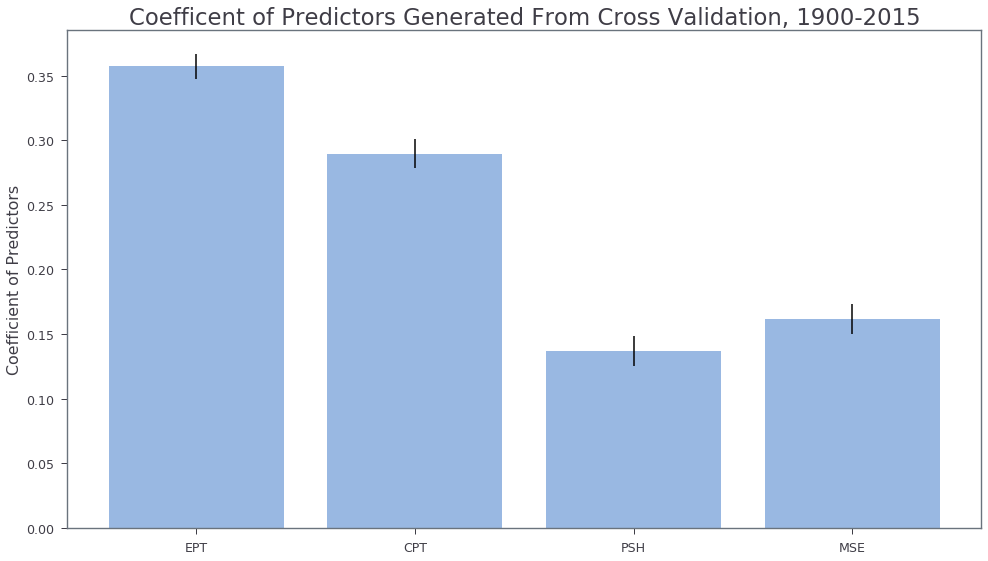

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,Standard Deviation,Mean
EPT new,0.009551,0.357306
CPT new,0.010980,0.289782
PSH new,0.011570,0.136764
MSE new,0.011590,0.161672


In [166]:
predictors = ['EPT', 'CPT', 'PSH', 'MSE']
x_pos = np.arange(len(predictors))
CTEs = [EPTregressionmean, CPTregressionmean, PSHregressionmean, MSEregressionmean]
error = [EPTregressionstd, CPTregressionstd, PSHregressionstd, MSEregressionstd]


fig, ax = plt.subplots(figsize=(14,8))
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Coefficient of Predictors', fontsize = 'large')
ax.set_xticks(x_pos)
ax.set_xticklabels(predictors)
ax.set_title('Coefficent of Predictors Generated From Cross Validation, 1900-2015',fontsize = 'xx-large')

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()
pd.DataFrame.from_items([('EPT new', EPTmodel), ('CPT new', CPTmodel), ('PSH new', PSHmodel), ('MSE new', MSEmodel)], orient='index', columns=['Standard Deviation', 'Mean'])

# Model

In [167]:
AIRI = 0.357*EPTnew + 0.290*CPTnew + 0.137*PSHnew + 0.161*MSEnew
AIRI

<xarray.DataArray (time: 88)>
array([-1.282219e-01, -6.301888e-01,  2.718403e-01, -1.523511e+00,
       -1.884610e+00,  3.744042e-01, -2.221314e-01,  4.207707e-02,
       -1.010261e-02, -1.127070e+00,  3.044126e-01, -7.318951e-01,
       -2.044424e-01,  5.301817e-01, -4.503920e-01, -2.336053e-01,
       -3.387236e-01, -6.247642e-01, -1.560645e-01,  4.946057e-01,
        1.251339e-02,  4.886167e-01, -2.996572e-02, -4.045575e-01,
        6.014105e-01,  5.346025e-01, -9.850980e-01, -3.017253e-01,
        3.384618e-01,  6.310337e-01, -1.756419e-01,  8.145465e-02,
        1.153707e+00, -5.235059e-01,  4.374912e-01, -3.807800e-01,
        7.360308e-01,  7.304271e-01,  8.137188e-01, -4.982417e-01,
        2.503647e-01, -1.763951e-02,  3.253410e-01,  6.937297e-01,
        1.663867e-01, -5.671589e-01,  1.199211e+00, -9.286347e-01,
       -3.555168e-01, -6.604247e-02, -4.978964e-01,  5.421967e-01,
        7.706405e-01,  8.022515e-01, -3.222879e-01,  6.576452e-01,
       -4.202976e-01,  9.531950e

In [172]:
#simple linear regression
AIRI2 = 0.475*EPTnew + 0.432*CPTnew + 0.386*PSHnew + 0.301*MSEnew
AIRI2

final2 = (AIRI2 * rainfallstd) + rainfallmean

In [173]:
#multiple linear regression
precip_jjas.time.data = EPTnew.time.data
rainfallmean = precip_jjas.mean()
rainfallstd = precip_jjas.std()

final = (AIRI * rainfallstd) + rainfallmean

In [174]:
finalcorrelation2 = correlation(final2, precip_jjas, dims='time')
print("simple linear regression")
print("correlation between final and precipitation", finalcorrelation2.data)
print()
finalcorrelation = correlation(final, precip_jjas, dims='time')
print("multiple linear regression")
print("correlation between final and precipitation", finalcorrelation.data)

simple linear regression
correlation between final and precipitation 0.619428325992251

multiple linear regression
correlation between final and precipitation 0.6296689023305145


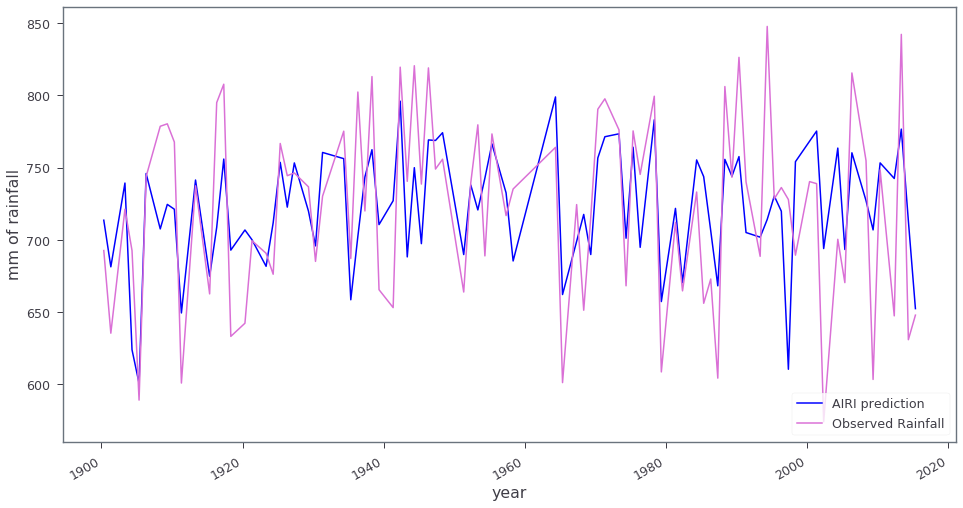

In [175]:
final.plot(label = 'AIRI prediction', color = 'blue')
precip_jjas.plot(label = 'Observed Rainfall', color = 'orchid')
plt.xlabel('year', fontsize = 'large')
plt.ylabel('mm of rainfall', fontsize = 'large')
plt.legend(loc='lower right')

In [ ]:
# Copyright (c) 2020 Medha Palavalli.